In [1]:
# %%
import os
import math
import numpy as np
import torch
import torch.nn as nn
from transformer import Transformer
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from tqdm import tqdm

# %%
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')

# EXPERIMENT 2:
EMB_DIM = 128
N_LAYERS = 2
N_HEADS = 8
FORWARD_DIM = 256
DROPOUT = 0.15
LEARNING_RATE = 2e-4
GRAD_CLIP = 1
BATCH_SIZE = 16
MAX_LEN = 128

In [2]:
print(f"On {device}")

On cpu


In [3]:
# Task 0: DataLoader and Preprocessing
class TasksData(Dataset):
    def __init__(self, data_dir, file, transform=None):
        self.data_dir = data_dir
        self.file = file
        text_file = os.path.join(data_dir, file)

        data_dict = {"src": [], "tgt": []}

        with open(text_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                src = line.split('OUT:')[0]
                src = src.split('IN:')[1].strip()
                tgt = line.split('OUT:')[1].strip()

                data_dict['src'].append(src)
                data_dict['tgt'].append(tgt)

        self.data = pd.DataFrame(data_dict)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = self.data['src'].iloc[idx] + ' <EOS>'
        tgt = '<SOS> ' + self.data['tgt'].iloc[idx] + ' <EOS>'
        return src, tgt

def create_vocab(dataset):
    vocab = set()

    for sample in dataset:
        vocab.update(sample.split())
    return vocab

# %%
# creating datasets
train_data = TasksData(data_dir='data/experiment2', file='tasks_train_length.txt')
test_data = TasksData(data_dir='data/experiment2', file='tasks_test_length.txt')

#creating source and target vocab
src_train_data = [src for src, tgt in train_data]
vocab_train_src = create_vocab(src_train_data)

tgt_train_data = [tgt for src, tgt in train_data]
vocab_train_tgt = create_vocab(tgt_train_data)

# we need to do word2idx to map the words to indexes. Bc the input for nn.Embedding has to be numbers
# since nn.Embdding has different weights in input andoutput embedding the same index will not be encoded to the same vector
word2idx_src = {w: idx + 1 for (idx, w) in enumerate(vocab_train_src)}
word2idx_src['<PAD>'] = 0

word2idx_tgt= {w: idx + 1 for (idx, w) in enumerate(vocab_train_tgt)}
word2idx_tgt['<PAD>'] = 0

def custom_collate_fn(batch):
    #input: batch of sentences
    # tokenize, word2idx, pad
    padded_src = pad_sequence([torch.tensor([word2idx_src[w] for w in src.split()]) for src, tgt in batch], batch_first=True, padding_value=0).to(device)
    padded_tgt = pad_sequence([torch.tensor([word2idx_tgt[w] for w in tgt.split()]) for src, tgt in batch], batch_first=True, padding_value=0).to(device)

    return padded_src, padded_tgt

# %%
# create dataloaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

In [4]:
# define the model
model = Transformer(
    src_vocab_size=len(word2idx_src),
    tgt_vocab_size=len(word2idx_tgt),
    src_pad_idx=word2idx_src['<PAD>'],
    tgt_pad_idx=word2idx_tgt['<PAD>'],
    emb_dim=EMB_DIM,
    num_layers=N_LAYERS,
    num_heads=N_HEADS,
    forward_dim=FORWARD_DIM,
    dropout=DROPOUT,
    max_len=MAX_LEN,
).to(device)

## ACCURACY FUNCTIONS

In [5]:
def token_lvl_accuracy(gt, pred):
    """
    gt = ground truth sequence
    pred = predicted sequence
    """
    correct = 0
    
    # get start and end
    eos_idx = word2idx_tgt['<EOS>']
    sos_idx = word2idx_tgt['<SOS>']
    # print(eos_idx)
    # print(sos_idx)
    pred = pred[-1]


    gt = gt[-1]

    # index of <SOS> and <EOS> tokens of the predicted sequence
    pred_start = 0
    pred_end = len(pred) if (eos_idx not in pred) else (pred == eos_idx).nonzero(as_tuple=True)[0].item()

    # index of <SOS> and <EOS> tokens of the ground truth sequence
    gt_start = (gt == sos_idx).nonzero(as_tuple=True)[0].item()
    gt_end = (gt == eos_idx).nonzero(as_tuple=True)[0].item()

    # slicing
    gt = gt[gt_start+1 : gt_end]
    pred = pred[pred_start+1 : pred_end]

    longer = gt if len(gt) > len(pred) else pred
    shorter = pred if len(gt) > len(pred) else gt

    longest_len = len(longer)

    shorter = torch.nn.functional.pad(shorter, (0, longest_len - len(shorter)), "constant", 0)

    correct = sum(longer == shorter)
    # print(longer)
    # print(shorter)
    # print(correct)
    return int(correct) / len(shorter) # same length as longer


def sequence_level_accuracy(gt, pred):

    pred = pred[-1]
    gt = gt[-1]

    if len(gt) != len(pred):
        return 0

    if sum(gt == pred) == len(gt):
        return 1

    return 0


## TRAINING

In [6]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx_tgt['<PAD>'])

# Training loop
num_epochs = 1
losses = []
accuraacy = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for step, (src, tgt) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader))):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()

        # output = model(src, tgt)
        output = model(src, tgt[:, :-1])
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:, 1:].contiguous().view(-1)

        loss = criterion(output, tgt)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
checkpoint_path = f"transformer_exp1_15.pth"
torch.save(
    {'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, checkpoint_path)


  0%|          | 0/1062 [00:00<?, ?it/s]

/home/jarl/UniStuff/ATNLP/crispy-fortnight/transformer.py:187: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch_1681837265408/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  K_transposed = K.T.permute(3, 1, 0, 2)
Epoch [1/1], Loss: 0.5721: 100%|██████████| 1062/1062 [02:56<00:00,  6.01it/s]


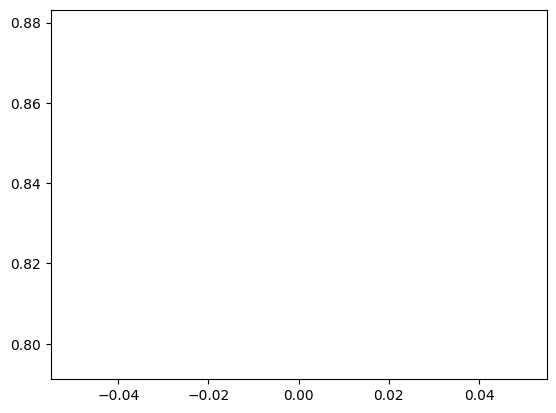

In [7]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(losses)

In [8]:
# Reverse the word-to-index mapping
idx2word_src = {idx: w for w, idx in word2idx_src.items()}
idx2word_tgt = {idx: w for w, idx in word2idx_tgt.items()}

def decode_indices(indices, idx2word):
    return ' '.join(idx2word[idx] for idx in indices if idx in idx2word and idx != word2idx_src['<PAD>'])

## TESTING

In [11]:
checkpoint_path = f"transformer_exp2_test.pth"
ckp = torch.load(checkpoint_path)
model.load_state_dict(ckp['model_state_dict'])
total_tokens = 0
correct_tokens = 0

def inference(input_seq: str):
    model.eval()
    pass

model.eval()

src, true_tgt = next(iter(test_loader))
print(src.shape)
src = src[0].unsqueeze(0).to(device)
true_tgt = true_tgt[0].unsqueeze(0).to(device)
# src, true_tgt = next(iter(test_loader))[0][0].unsqueeze(0).to(device)

print(src)
tgt = torch.tensor([[word2idx_tgt['<SOS>']]]).to(device)
# tgt = torch.tensor([[word2idx_tgt['<SOS>']]]).to(device)

# print(f'tgt {tgt.shape}')
# print(f'src {src.shape}')
iterations = MAX_LEN - 1
pred_sequence = [tgt.item()]
# print(pred_sequence)

for i in range(iterations):
    with torch.no_grad():
        # print(tgt)
        output = model.forward(src, tgt)
        predictions = nn.functional.softmax(output[:, -1, :], dim=-1)
        # print("argmax:", predictions.argmax(-1).shape)
        next_token = predictions.argmax(-1).item()


        # next_token_tensor = torch.tensor([[next_token]]).to(device)
        # tgt = torch.cat([tgt, next_token_tensor], dim=1)
        
        pred_sequence.append(next_token)
        tgt = torch.tensor(pred_sequence).unsqueeze(0).to(device)

        if next_token == word2idx_tgt['<EOS>']:
            break
        
        # print(tgt.shape)
        # print("tgt", tgt)

print(f'ground t: {true_tgt}')
print(f'predicted: {tgt}')
print(token_lvl_accuracy(true_tgt, tgt))


torch.Size([16, 10])
tensor([[ 2,  5, 11,  4,  3,  2,  5, 10,  8,  0]])
ground t: tensor([[8, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 3, 5, 3, 5, 3, 5, 3,
         5, 6]])
predicted: tensor([[8, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3,
         5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3,
         5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3,
         5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3,
         5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3,
         5, 3, 5, 3, 5, 3, 5, 3]])
0.12598425196850394


In [ ]:
print(word2idx_tgt['<SOS>'])
print(word2idx_tgt['<EOS>'])

1
4


# BATCH INFERENCE

In [33]:
checkpoint_path = "transformer_exp2_test.pth"
ckp = torch.load(checkpoint_path)
model.load_state_dict(ckp['model_state_dict'])
total_tokens = 0
correct_tokens = 0

src, tgt = next(iter(test_loader))
# print(src.shape, tgt.shape)

gt_avgs = {}
command_avgs = {}

# avg_token = []
# avg_seq = []

n_batches = len(test_loader)
counter = 0
# l = 0
for src_batch, tgt_batch in test_loader:
#     # if l > 5:
#     #     break
    for src, tgt in zip(src_batch, tgt_batch):
        len_gt = len(tgt)
        len_command = len(src)

        src = src.unsqueeze(0).to(device)
        true_tgt = tgt.unsqueeze(0).to(device)
        tgt = torch.tensor([[word2idx_tgt['<SOS>']]]).to(device)
        
        iterations = MAX_LEN - 1
        pred_sequence = [tgt.item()]
        # print(tgt.shape)
        # print(src.shape, true_tgt.shape)

        for i in range(iterations):
            with torch.no_grad():
                output = model.forward(src, tgt)
                predictions = nn.functional.softmax(output[:, -1, :], dim=-1)
                next_token = predictions.argmax(-1).item()

                pred_sequence.append(next_token)
                tgt = torch.tensor(pred_sequence).unsqueeze(0).to(device)
                
                # Stop if end of sequence
                if next_token == word2idx_tgt['<EOS>']:
                    break                

        tok_lvl_acc = token_lvl_accuracy(true_tgt, tgt)
        if len_gt in gt_avgs:
            gt_avgs[len_gt].append(tok_lvl_acc)
        else:
            gt_avgs[len_gt] =[tok_lvl_acc]
            
        if len_command in command_avgs:
            command_avgs[len_command].append(tok_lvl_acc)
        else:
            command_avgs[len_command] =[tok_lvl_acc]
    
    counter += 1
    print(counter, "/", n_batches)
        
        

1 / 245
2 / 245
3 / 245
4 / 245


KeyboardInterrupt: 

In [26]:
print(command_avgs)
print(gt_avgs)

{10: [0.12598425196850394, 0.12598425196850394, 0.12598425196850394, 0.07575757575757576, 0.15748031496062992, 0.16666666666666666, 0.1889763779527559, 0.15748031496062992, 0.15748031496062992, 0.4583333333333333, 0.12598425196850394, 0.16666666666666666, 0.21333333333333335, 0.12598425196850394, 0.1889763779527559, 0.12598425196850394, 0.12598425196850394, 0.1889763779527559, 0.24242424242424243, 0.9166666666666666, 0.1889763779527559, 0.15748031496062992, 0.5416666666666666, 0.4166666666666667, 0.12598425196850394, 0.09448818897637795, 0.12598425196850394, 0.16535433070866143, 0.09448818897637795, 0.6666666666666666, 0.7083333333333334, 0.15748031496062992, 0.12598425196850394, 0.21333333333333335, 0.12598425196850394, 0.12598425196850394, 0.15748031496062992, 0.625, 0.12598425196850394, 0.12598425196850394, 0.18110236220472442, 0.1415929203539823, 0.1889763779527559, 0.1889763779527559, 0.13636363636363635, 0.15748031496062992, 0.15748031496062992, 0.12598425196850394, 0.21333333333

{10: 0.23398753480998394}
{26: 0.23398753480998394}


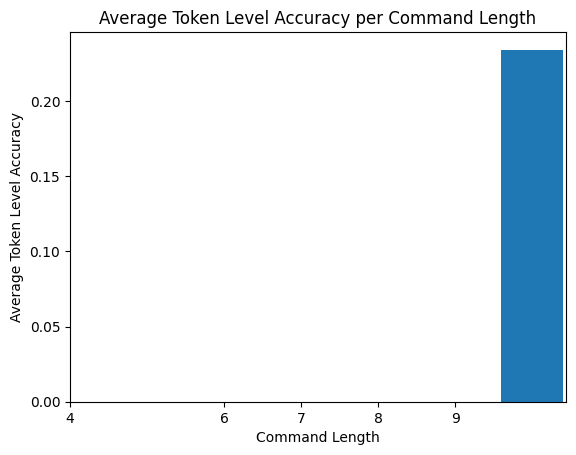

In [31]:
# in command_avgs the key is the length of the command and the value is the list of accuracies for that length
# plot the average accuracy for each command length

command_avgs_avg = {k: sum(v) / len(v) for k, v in command_avgs.items()}
gt_avgs_avg = {k: sum(v) / len(v) for k, v in gt_avgs.items()}
print(command_avgs_avg)
print(gt_avgs_avg)

plt.figure(2)
plt.bar(list(command_avgs_avg.keys()), list(command_avgs_avg.values()))
plt.xlabel("Command Length")
plt.ylabel("Average Token Level Accuracy")
plt.title("Average Token Level Accuracy per Command Length")
plt.xticks([4, 6, 7, 8, 9])
plt.show()

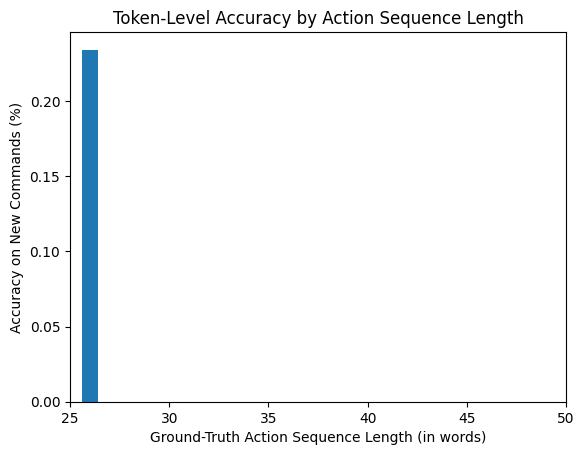

In [30]:
plt.figure(2)
plt.bar(list(gt_avgs_avg.keys()), list(gt_avgs_avg.values()))
plt.xlabel("Ground-Truth Action Sequence Length (in words)")
plt.ylabel("Accuracy on New Commands (%)")
plt.title("Token-Level Accuracy by Action Sequence Length")
plt.xticks([25, 30, 35, 40, 45, 50])
plt.show()